# Simulation of Electric Potential Spread

## Introduction

*TODO*

In [136]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
try:
    import seaborn
except ImportError:
    pass

In [129]:
class FieldModel:
    """ Model of a regular resistor grid. All nodes in the grid are connected to their direct neighbors with resitors.
    """
    def __init__(self, shape=(128, 128), extent=(1, 1)):
        self._shape = np.asarray(shape)
        self._extent = np.asarray(extent)
        self.reset()
        
    def reset(self):
        self._step = self._extent / self._shape
        self._potential_field = np.zeros(self._shape)
        self._temporary_field = np.zeros(self._shape)
        self._sx = np.ones(self._shape - [0, 1])
        self._sy = np.ones(self._shape - [1, 0])
        self._clamps = []
        self._inductions = []
        
    @property
    def shape(self):
        return self._shape
    
    @shape.setter
    def shape(self, s):
        self._shape = np.asarray(s)
        self.reset()
        
    @property
    def extent(self):
        return self._extent
    
    @extent.setter
    def extent(self, e):
        self._extent = np.asarray(e)
        self.reset()
        
    @property
    def dx(self):
        return self._step[0]
        
    @property
    def dy(self):
        return self._step[1]
        
    @property
    def potential(self):
        return self._potential_field
        
    @property
    def current(self):
        return np.diff(self._potential_field, axis=1) * self._sx, np.diff(self._potential_field, axis=0) * self._sy
        
    def add_clamp(self, x, y, u):
        self._clamps.append((x, y, u))

    def add_induction(self, x, y, d, i):
        if d == 'r':
            u = i / self._sx[x, y]
            self._inductions.append((x, y, x, y + 1, u))
        elif d == 'd':
            u = i / self._sy[x, y]
            self._inductions.append((x, y, x + 1, y, u))
        elif d == 'l':
            u = i / self._sx[x, y - 1]
            self._inductions.append((x, y, x, y - 1, u))
        elif d == 'u':
            u = i / self._sy[x - 1, y]
            self._inductions.append((x, y, x - 1, y, u))
        else:
            raise AssertionError("direction must be one of l/r/u/d.")

    def set_conductivity(self, i, j, d, s):
        if d == 'r':
            self._sx[i, j] = s
        elif d == 'd':
            self._sy[i, j] = s
        elif d == 'l':
            self._sx[i, j - 1] = s
        elif d == 'u':
            self._sy[i - 1, j] = s
        else:
            raise AssertionError("direction must be one of l/r/u/d.")
        
    def iterate(self, n_iter):
        ws = self._sy[1:, 1:-1] + self._sy[:-1, 1:-1] + self._sx[1:-1, 1:] + self._sx[1:-1, :-1]
        for _ in range(n_iter):
            self._temporary_field[1:-1, 1:-1] = (self._potential_field[2:, 1:-1] * self._sy[1:, 1:-1]  +
                                                 self._potential_field[:-2, 1:-1] * self._sy[:-1, 1:-1] +
                                                 self._potential_field[1:-1, 2:] * self._sx[1:-1, 1:] +
                                                 self._potential_field[1:-1, :-2] * self._sx[1:-1, :-1]) / ws

            self.apply_boundary_closed(self._potential_field, self._temporary_field, self._sx, self._sy)

            na = np.isnan(self._temporary_field)
            self._temporary_field[na] = self._potential_field[na]

            self._potential_field, self._temporary_field = self._temporary_field, self._potential_field

            for i, j, u in self._clamps:
                self._potential_field[i, j] = u

            for i1, j1, i2, j2, du in self._inductions:
                u = self._potential_field[i2, j2] - self._potential_field[i1, j1]
                r = (du - u) / 2
                self._potential_field[i1, j1] -= r
                self._potential_field[i2, j2] += r

    @staticmethod
    def apply_boundary_zero(U, V, sx, sy):
        V[0, 1:-1] =0
        V[-1, 1:-1] = 0
        V[1:-1, 0] = 0
        V[1:-1, -1] = 0
        V[0, 0] = 0
        V[-1, 0] = 0
        V[0, -1] = 0
        V[-1, -1] = 0
        return V

    @staticmethod
    def apply_boundary_open(U, V, sx, sy):
        V[0, 1:-1] = U[1, 1:-1]
        V[-1, 1:-1] = U[-2, 1:-1]
        V[1:-1, 0] = U[1:-1, 1]
        V[1:-1, -1] = U[1:-1, -2]
        V[0, 0] = (U[0, 1] + U[1, 0]) * 0.5
        V[-1, 0] = (U[-1, 1] + U[-2, 0]) * 0.5
        V[0, -1] = (U[0, -2] + U[1, -1]) * 0.5
        V[-1, -1] = (U[-1, -2] + U[-2, -1]) * 0.5
        return V

    @staticmethod
    def apply_boundary_closed(U, V, sx, sy):
        V[0, 1:-1] = (U[1, 1:-1] * sy[0, 1:-1] + U[0, 2:] * sx[0, 1:] + U[0, :-2] * sx[0, :-1]) / (sy[0, 1:-1] + sx[0, 1:] + sx[0, :-1])
        V[-1, 1:-1] = (U[-2, 1:-1] * sy[-1, 1:-1] + U[-1, 2:] * sx[-1, 1:] + U[-1, :-2] * sx[-1, :-1]) / (sy[-1, 1:-1] + sx[-1, 1:] + sx[-1, :-1])
        V[1:-1, 0] = (U[2:, 0] * sy[1:, 0] + U[:-2, 0] * sy[:-1, 0] + U[1:-1, 1] * sx[1:-1, 0]) / (sy[1:, 0] + sy[:-1, 0] + sx[1:-1, 0])
        V[1:-1, -1] = (U[2:, -1] * sy[1:, -1] + U[:-2, -1] * sy[:-1, -1] + U[1:-1, -2] * sx[1:-1, -1]) / (sy[1:, -1] + sy[:-1, -1] + sx[1:-1, -1])
        
        V[0, 0] = (U[1, 0] * sy[0, 0] + U[0, 1] * sx[0, 0]) / (sy[0, 0] + sx[0, 0])
        V[-1, 0] = (U[-2, 0] * sy[-1, 0] + U[-1, 1] * sx[-1, 0]) / (sy[-1, 0] + sx[-1, 0])
        V[0, -1] = (U[1, -1] * sy[0, -1] + U[0, -2] * sx[0, -1]) / (sy[0, -1] + sx[0, -1])
        V[-1, -1] = (U[-2, -1] * sy[-1, -1] + U[-1, -2] * sx[-1, -1]) / (sy[-1, -1] + sx[-1, -1])
        return V

    def load_model(self, filename):
        img = imread(filename)
        r, g, b, a = np.rollaxis(img, axis=-1)
        self.shape = img.shape[:2]
        self.extent = self.shape * 1e-4  # 1 pixel is 0.1mm

        # Conductivity values taken from
        # http://www.itis.ethz.ch/virtual-population/tissue-properties/database/low-frequency-conductivity/

        cond = np.zeros(r.shape)
        cond[(r == 1) & (g == 0) & (b == 0)] = 3.69e-1  # White Matter
        cond[(r == 1) & (g == 0) & (b == 1)] = 1.85e-1  # Grey Matter
        cond[(r == 0) & (g == 0) & (b == 1)] = 1.79e0  # Cerebrospinal Fluid
        cond[(r == 0) & (g == 1) & (b == 0)] = 9.5e-2  # Bone
        cond[(r == 1) & (g == 1) & (b == 0)] = 1.2e-3  # Skin (wet)

        self._sx = (cond[:, :-1] + cond[:, 1:]) * 0.5 / self.dx
        self._sy = (cond[:-1, :] + cond[1:, :]) * 0.5 / self.dy

    def __str__(self):
        
        s = np.empty(self.shape * [5, 16], dtype='<U1')
        s[:] = '.'
        
        for i in 
        
        s = '\n'.join(''.join(line) for line in s)
        
        s += '\n\n'
        
        #s = ''
        for i in range(self.shape[0]):
            s += '....' + '            '.join('{:+2.3f}V'.format(k) for k in self.potential[i])
            s += '\n   O'
            for k, cond in zip(self.current[0][i], self._sx[i]):
                if cond > 0:
                    s += '--------{}---------O'.format({-1: '<', 0: '=', 1: '>'}[np.sign(k)])
                else:
                    s += '                  O'
            #s + ('--------{}---------'.join(['O'] * self.shape[1])).format(*[{-1: '<', 0: '=', 1: '>'}[np.sign(k)] for k in self.current[0][i]])

            if i < self.shape[0] - 1:
                s += '\n   '
                s += ' ' if self._sy[i][0] == 0 else '|'
                for k, sx, sy in zip(abs(self.current[0][i]), self._sx[i], self._sy[i][1:]):
                    v_line = ' ' if sy == 0 else '|'
                    if sx == 0:
                        s += '                  ' + v_line
                    else:
                        s += '      {:2.3f}A      '.format(k) + v_line
                s += '\n   ' + ('                  '.join([' ' if sy == 0 else '|' for sy in self._sy[i]]))
                s += '\n   ' + ('           '.join(['{} {:2.3f}A'] * self.shape[1])).format(*[b for a in zip([{-1: '^', 0: '=', 1: 'v'}[np.sign(k)] for k in self.current[1][i]],
                                                                                                             np.abs(self.current[1][i])) for b in a])
                s += '\n   ' + ('                  '.join([' ' if sy == 0 else '|' for sy in self._sy[i]]))
            else:
                s += '\n    '
                for k, cond in zip(abs(self.current[0][i]), self._sx[i]):
                    if cond == 0:
                        s += '                  '.format(k) + ' '
                    else:
                        s += '      {:2.3f}A      '.format(k) + ' '
                #s += '\n    ' + ' '.join('      {:2.3f}A      '.format(k) for k in abs(self.current[0][i])) + ' '

            s += '\n'
        return s
    

In [130]:
model = FieldModel(shape=(3, 3), extent=(3, 3))
model.add_clamp(1, 0, 3)
model.add_clamp(1, -1, -3)
model.set_conductivity(2, 0, 'u', 0)
model.set_conductivity(2, 0, 'r', 0)
model.set_conductivity(1, 0, 'r', 0)
model.set_conductivity(1, 2, 'l', 0)
model.set_conductivity(0, 2, 'l', 0)
model.set_conductivity(0, 2, 'd', 0)
model.iterate(100)
print(model)

................................................
................................................
................................................
................................................
................................................
................................................
................................................
................................................
................................................
................................................
................................................
................................................
................................................
................................................
................................................

....+2.000V            +1.000V            +0.000V
   O--------<---------O                  O
   |      1.000A      |                   
   |                  |                   
   v 1.000A           ^ 1.000A           = 0.000A
   |                  |            

![title](model.png)

red: white matter, pink: grey matter, blue: fluid, green: bone, yellow: skin

In [132]:
borders = imread('edges_small.png')
probes = [(48, 70), (48, 150), (53, 239), (70, 299)]
clamps = [(121, 74, -1), (120, 70, 1),
          (137, 260, 1), (137, 265, -1)]

# borders = imread('edges.png')
# probes = [(96, 139), (96, 300), (107, 478), (139, 598)]
# clamps = [['A', (242, 146, 1), (245, 140, -1)],
#           ['B', (224, 291, -1), (225, 292, 1)],
#           ['C', (259, 430, 1), (257, 434, -1)],
#           ['D', (273, 520, 1), (274, 530, -1)]]

In [140]:
model = FieldModel()
model.load_model('model_small.png')
for c in clamps:
    model.add_clamp(*c)
model.iterate(1000)

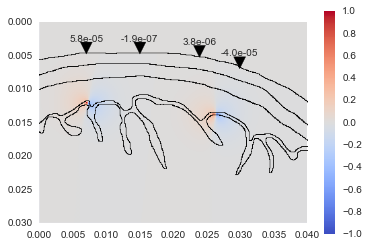

In [149]:
U = model._potential_field
extent = model.extent
shape = model.shape
dx, dy = model.dx, model.dy

plt.imshow((np.abs(U))**0.5*np.sign(U), extent=[0, extent[1], extent[0], 0], cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.imshow(borders, extent=[0, extent[1], extent[0], 0])
plt.grid('off')

for p in probes:
    x = p[1] * dx
    y = p[0] * dy
    plt.annotate('{:.1e}'.format(model.potential[p[0], p[1]]), xy=(x, y), xytext=(x, y-0.002), ha='center', arrowprops=dict(facecolor='black', shrink=0.001))

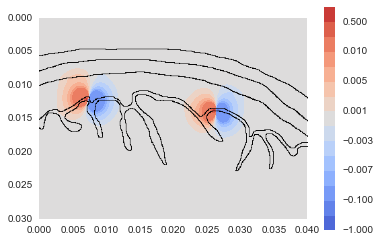

In [146]:
levels = [-1, -0.5, -1e-1, -1e-2, -0.75e-2, -0.5e-2, -0.25e-2, -1e-3, 1e-3, 0.25e-2, 0.5e-2, 0.75e-2, 1e-2, 1e-1, 0.5, 1]
colors = seaborn.color_palette("coolwarm", len(levels)-1)
plt.contourf(U, levels=levels, colors=colors, extent=[0, extent[1], 0, extent[0]], linewidth=0, zorder=1)
plt.colorbar()
plt.imshow(borders, extent=[0, extent[1], extent[0], 0], zorder=2)
plt.grid('off')